# Fall Problem Session 6
## Forecasting The Bachelorette and Pumpkin Spice II

In the second of two time series based problem sessions you build upon your work in `Fall Problem Session 5`. In particular you will look to build the best forecast you can for the Bachelorette IMDB ratings. Afterwards you will be introduced to seasonal ARIMA models with the pumpkin spice Google trends data.

The problems in this notebook will cover the content covered in our `Time Series Forecasting` lectures including:
- `Averaging and Smoothing`,
- `Stationarity and Autocorrelation` and
- `ARIMA`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime

set_style("whitegrid")

#### 1. The Bachelorette

##### a.

- Reload the Bachelorette IMDB data stored in `bachelorette.csv` in the `Data` folder. 
- Look at the first five rows.
- Then make the training split.

In [2]:
tv = pd.read_csv("../Data/the_bachelorette.csv")

In [14]:
tv.head(30)

,episode_number,title,season,season_episode_number,imdb_rating
0,1,Episode #1.1,1,1,5.901235
1,2,Episode #1.2,1,2,5.801235
2,3,Episode #1.3,1,3,4.901235
3,4,Episode #1.4,1,4,5.401235
4,5,Episode #1.5,1,5,5.401235
5,6,Episode #1.6,1,6,5.401235
6,7,Episode #1.7,1,7,5.401235
7,8,Trista & Ryan's Wedding: Part 1,1,8,5.701235
8,9,Trista & Ryan's Wedding: Part 2,1,9,5.501235
9,10,Trista & Ryan's Wedding: Part 3,1,10,5.501235


In [4]:
tv_train = tv.iloc[:-3].copy()
tv_test = tv.drop(tv_train.index).copy()

##### b.

Here is a refresher on the columns of this data.

- `episode_number` is the number of the episode with respect to the entire series run,
- `title` is the title of the episode,
- `season` is the number of the season in which the episode aired,
- `season_episode_number` is the number of the episode with respect to the season in which it aired,
- `imdb_rating` is the average rating of the episode among IMDB's users.

##### c.

The first model you will fit is a moving average model. In this problem you will be tuning the moving average window size, $q$, to find the value that minimizes the average cross-validation root mean squared error (RMSE).

Fill in the missing chunks of code to perform hyperparameter tuning for $q$.

In [6]:
## import what you need for CV
from sklearn.model_selection import TimeSeriesSplit

## import mse
from sklearn.metrics import mean_squared_error

In [33]:
cv = TimeSeriesSplit(10, test_size = 3)

start = 2
end = 31
ma_rmses = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = tv_tt.imdb_rating[-q:].mean()
        
        ma_rmses[i,j] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values, pred*np.ones(len(tv_ho))))
        j = j + 1
    i = i + 1

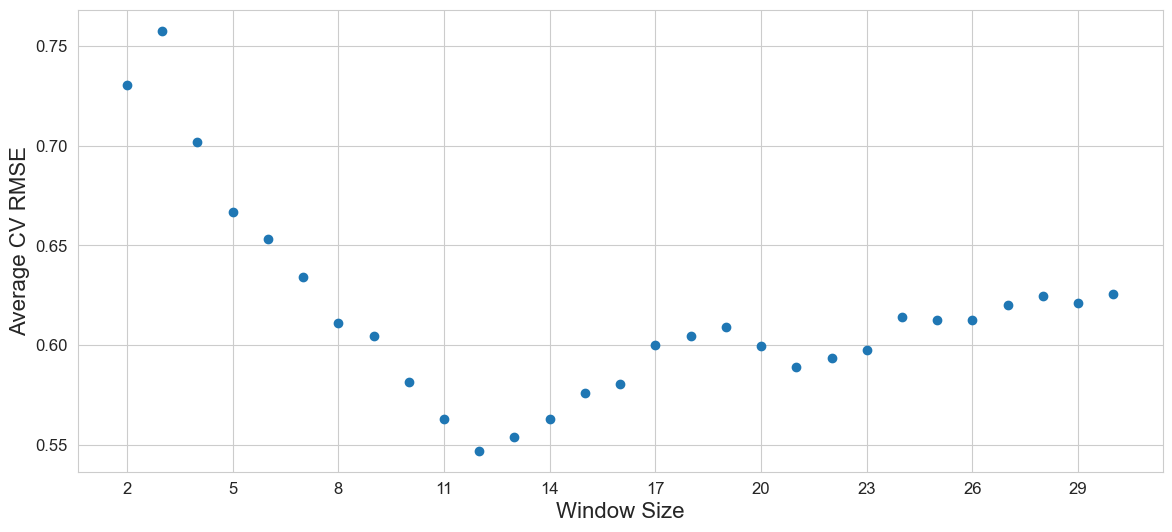

In [34]:
## This will plot the average CV RMSE
## against the window size
plt.figure(figsize=(14,6))

plt.scatter(range(start,end), np.mean(ma_rmses, axis=0))

plt.xlabel("Window Size", fontsize=16)
plt.ylabel("Average CV RMSE", fontsize=16)

plt.xticks(range(start, end, 3), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [35]:
print("The window size that minimized the avg. cv rmse",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ma_rmses, axis=0))],
      "\b.",
      "It had a mean cv rmse of", 
      np.round(np.min(np.mean(ma_rmses, axis=0)), 3))

The window size that minimized the avg. cv rmse was q = 12. It had a mean cv rmse of 0.547


##### d.

The second model you will try is an exponential smoothing model.

Because these data exhibit a trend but not seasonality we will fit a double exponential smoothing model. For this we will want to find the best $\alpha$ (The smoothing on the time series) and $\beta$ (the smoothing on the trend component).

Fill in the missing code chunks below to perform a grid search for the values of $\alpha$ and $\beta$ that minimize the average CV RMSE. (Note that a grid search is what we call it when you perform hyperparameter tuning with a grid of possible hyperparameter values).

In [36]:
## import what you need to make an exponential smoothing mod
from statsmodels.tsa.holtwinters import Holt

In [37]:
alphas = np.arange(0, 0.2, .01)
betas = np.arange(0, 0.2, .01)

exp_rmses = np.zeros((10, len(alphas), len(betas)))

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    j = 0
    for alpha in alphas:
        k = 0
        for beta in betas:
            #print("alpha =", alpha,
            #         "beta =", beta)

            exp_smooth = Holt(tv_tt.imdb_rating).fit(smoothing_level=alpha, 
                                                          smoothing_trend=beta,
                                                          optimized=False)

            exp_rmses[i,j,k] = np.sqrt(mean_squared_error(tv_ho.imdb_rating,exp_smooth.forecast(len(tv_ho))))
            
            # print(exp_rmses[i,j,k])
            
            
            k = k + 1
        j = j + 1
    i = i + 1

In [38]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_rmses, axis=0), axis=None), 
                           np.mean(exp_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmses, axis=0), axis=None), 
                 np.mean(exp_rmses, axis=0).shape)

(1, 11)

In [39]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmses, axis=0)[exp_ind],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.01 and beta =  0.11
This model had an avg cv rmse of 0.555


##### e.

The final model you will try is an ARIMA model. 

First let's check the stationarity assumption for this time series. Make an autocorrelation plot of the training data. If you find that the ACF plot indicates that the time series is non-stationary, plot the ACF of the time series' first differences. Do these appear to be stationary?

In [40]:
import statsmodels.api as sm

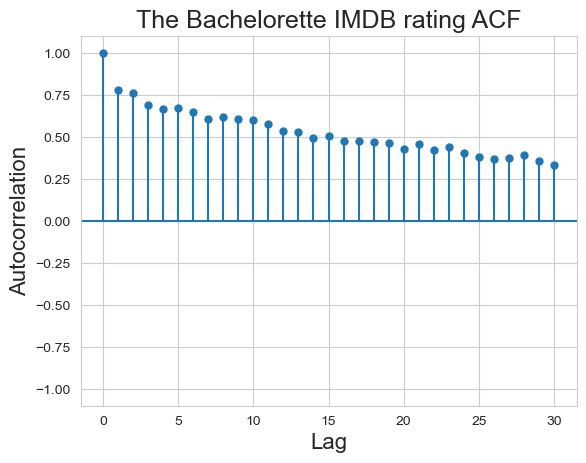

In [41]:
#fig, ax = plt.subplots(1, 1, figsize=(8,6))

## fill in the missing code to make the ACF for the original data
sm.graphics.tsa.plot_acf(tv_train.imdb_rating.values,
                            alpha = None,
                            lags = 30)



plt.title('The Bachelorette IMDB rating ACF', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

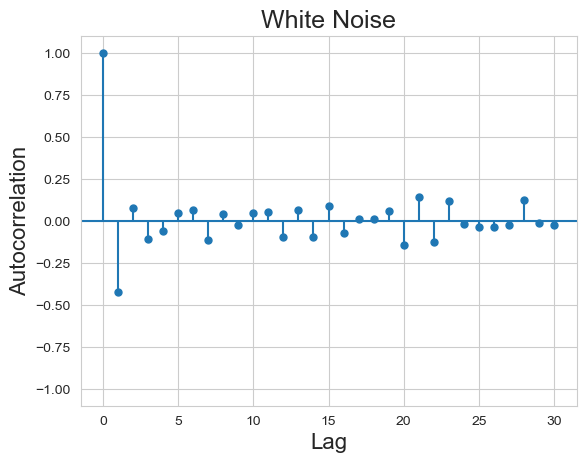

In [42]:
sm.graphics.tsa.plot_acf(tv_train.imdb_rating.diff()[1:],
                            alpha = None,
                            lags = 30)

plt.title('White Noise', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

##### f.

From what we saw above we should set our $d$ value in the ARIMA model to $1$. This means we still have to perform hyperparameter tuning to find the values of $p$ and $q$ that give us the lowest mean CV RMSE.

In [53]:
## import SARIMAX
from statsmodels.tsa.api import SARIMAX

In [50]:
arima_rmses = np.zeros((10, 3, 3))

ps = range(1,4)
qs = range(1,4)

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    j = 0
    for p in ps:
        k = 0
        for q in qs:
            arima = SARIMAX(tv_tt.imdb_rating.values,order=(p,1,q)).fit(maxiter=200)
            
            
            arima_rmses[i,j,k] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values,arima.forecast(len(tv_ho))))
            
            k = k +1
        j = j + 1
    i = i +1
    print(i)

C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


4


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


6


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


7


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


9


C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


10


In [51]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                             np.mean(arima_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                 np.mean(arima_rmses, axis=0).shape)

(0, 2)

In [52]:
print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(1,4)[arima_ind[0]],
         "and q = ", range(1,4)[arima_ind[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_rmses, axis=0)[arima_ind],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  1 and q =  3
This model had an avg cv mse of 0.641


##### g.

Compare the best RMSE you attained in this notebook to the best RMSE for the baseline models in the completed version of `Fall Problem Session 5`.

Plot the best forecast with the training and test data. What is the RMSE of the forecast on the test data?

In [54]:
arima = SARIMAX(tv_train.imdb_rating.values,order=(1,1,3)).fit(maxiter=200)

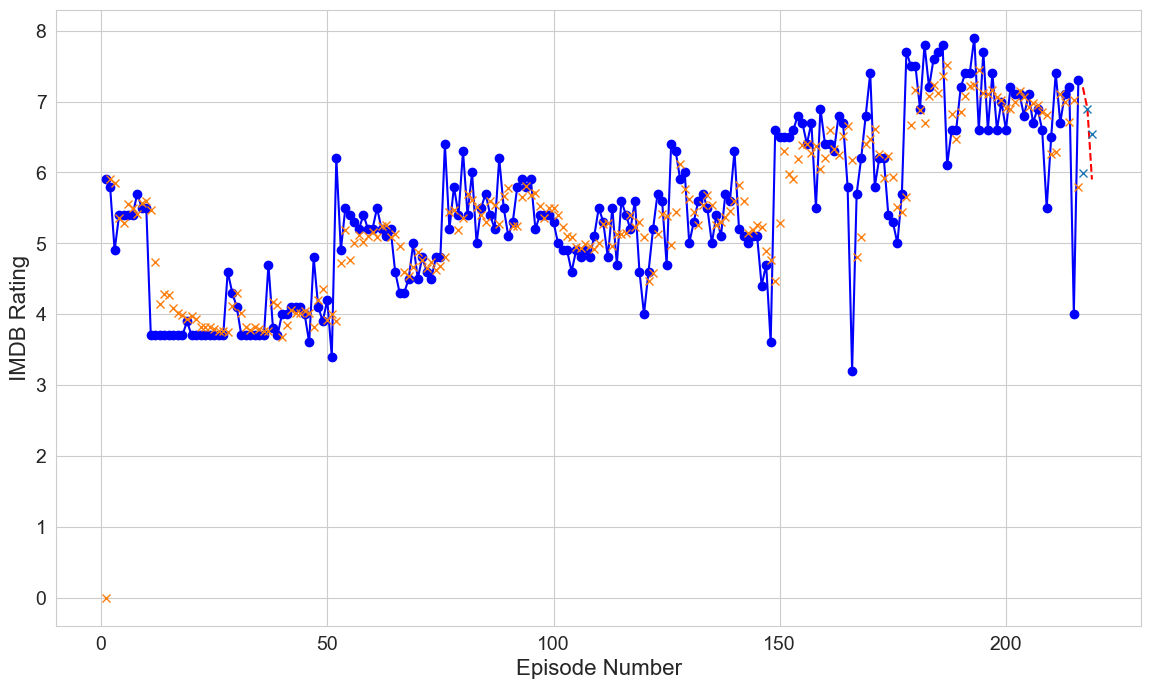

In [56]:
plt.figure(figsize=(14,8))


plt.plot(tv_train.episode_number,tv_train.imdb_rating.values,'-ob')
plt.plot(tv_test.episode_number,tv_test.imdb_rating.values,'--r')
plt.plot(tv_test.episode_number,arima.forecast(len(tv_test)),'x')
plt.plot(tv_train.episode_number,arima.fittedvalues,'x')




plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Rating", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.show()

#### 2. Pumpkin spice seasonal ARIMA

In this problem you will be introduces to seasonal ARIMA models with the pumpkin spice Google trend data. This will be a surface level introduction, for a more in depth look check out the time series practice problems `jupyter notebook`.

##### a.

Load the data stored in `pumpkin_spice.csv` in the `Data` folder then look at the first five rows. Then make a train test split setting aside all observations after December 31, 2021 aside as the test set.

In [57]:
pumpkin = pd.read_csv("../Data/pumpkin_spice.csv",
                         parse_dates = ["Month"])

In [58]:
pumpkin.head()

,Month,interest_level
0,2004-01-01,2
1,2004-02-01,1
2,2004-03-01,0
3,2004-04-01,0
4,2004-05-01,1


In [60]:
p_train = pumpkin.loc[pumpkin.Month <= datetime(2021,12,31)]
p_test = pumpkin.loc[pumpkin.Month > datetime(2021,12,31)]

##### b.

In lecture we talked about first differencing non-stationary time series exhibiting a trend to create a, seemingly, stationary time series.

This can also be done for seasonal data. Suppose that we suspect a time series, $\left\lbrace y_t \right\rbrace$ exhibits seasonality where a season lasts $m$ time steps. Then the first seasonal differenced time series is:

$$
\nabla_s y_t = y_t - y_{t-m}.
$$

Plot the autocorrelation of the training set, then perform first seasonal differencing on these data and plot the autocorrelation of the first seasonal differenced series.

Does the differenced series appear less likely to violate stationarity?

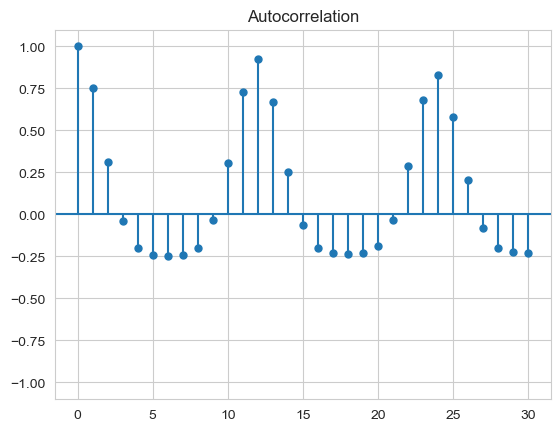

In [63]:
#fig,ax = plt.subplots(1,1, figsize=(12,6))

sm.graphics.tsa.plot_acf(p_train.interest_level,
                            alpha = None,
                            lags = 30)




plt.ylim([-1.1,1.1])

plt.show()

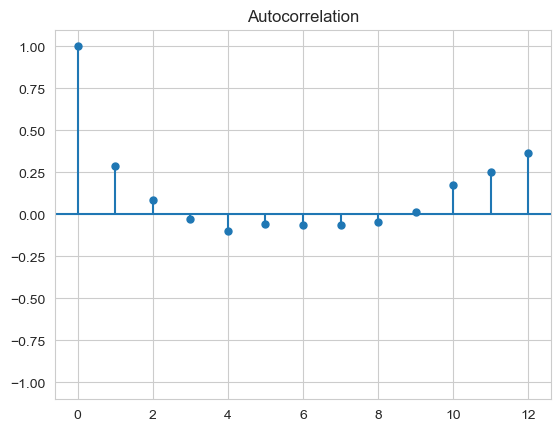

In [70]:
sm.graphics.tsa.plot_acf(p_train.interest_level.diff(12)[12:],
                            alpha = None,
                            lags = 12)




plt.ylim([-1.1,1.1])

plt.show()

1


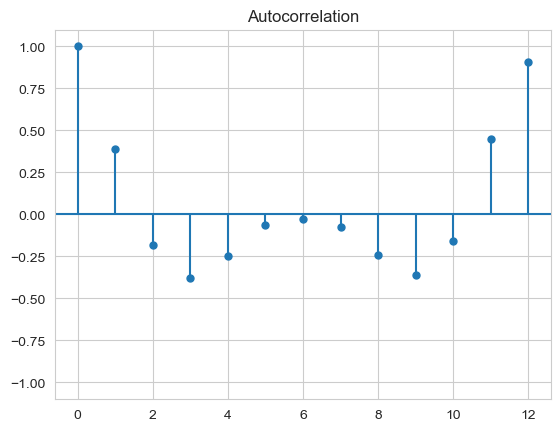

2


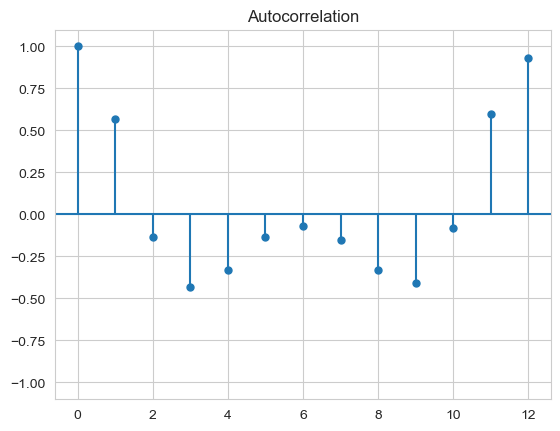

3


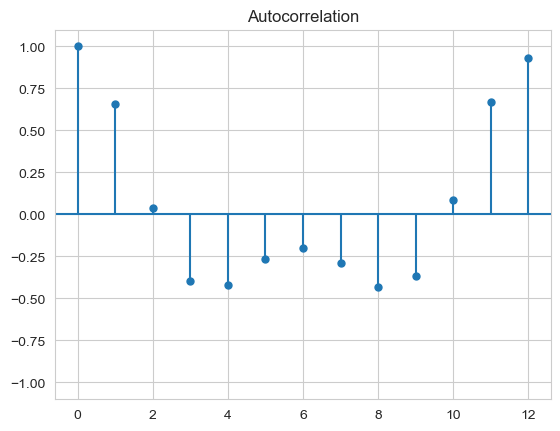

4


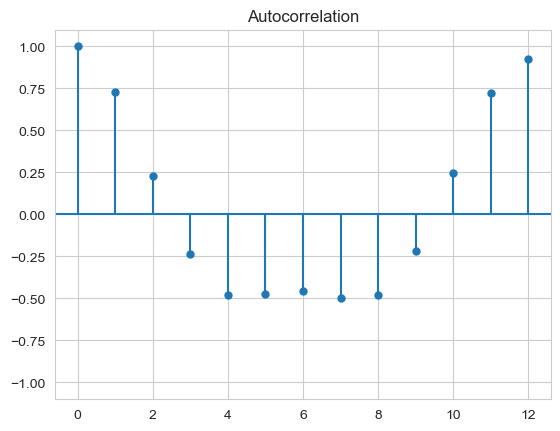

5


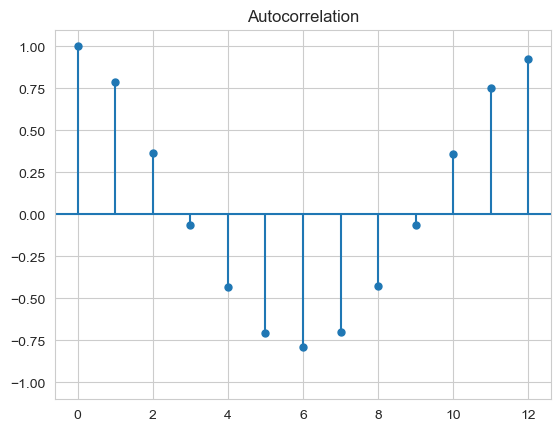

6


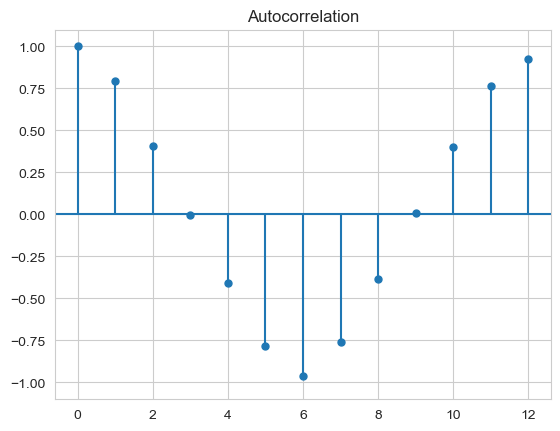

7


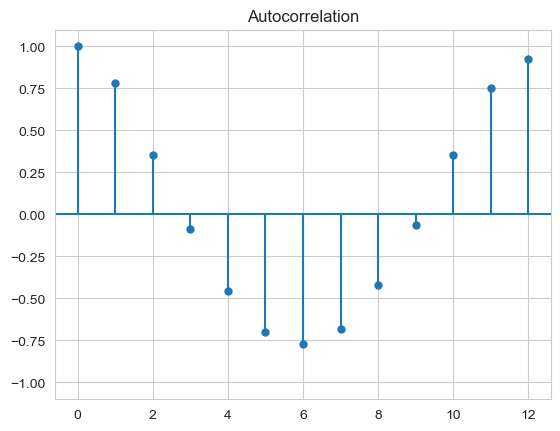

8


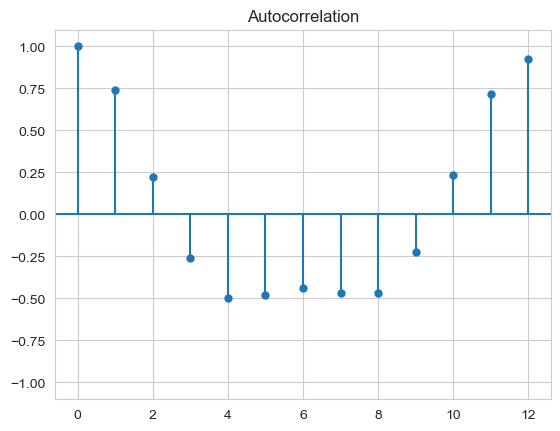

9


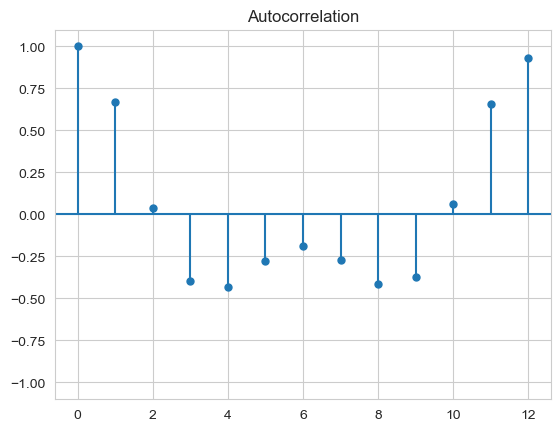

10


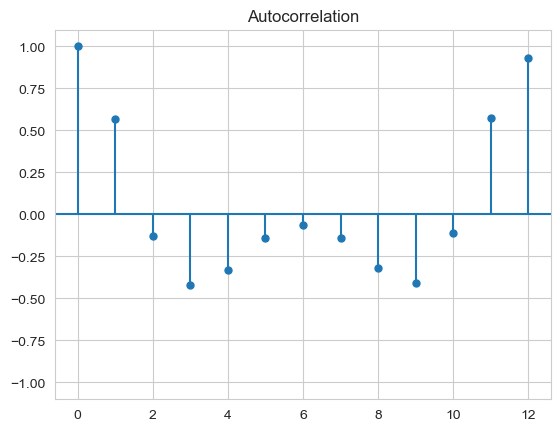

11


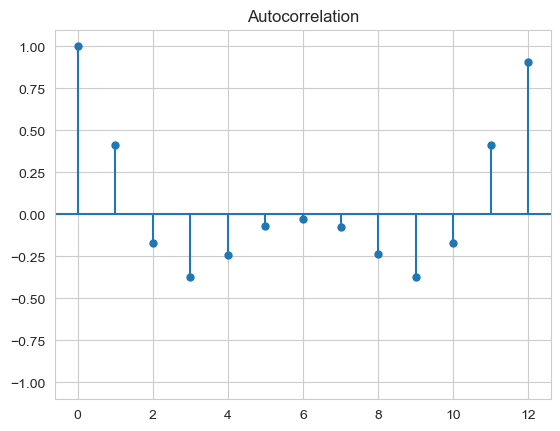

12


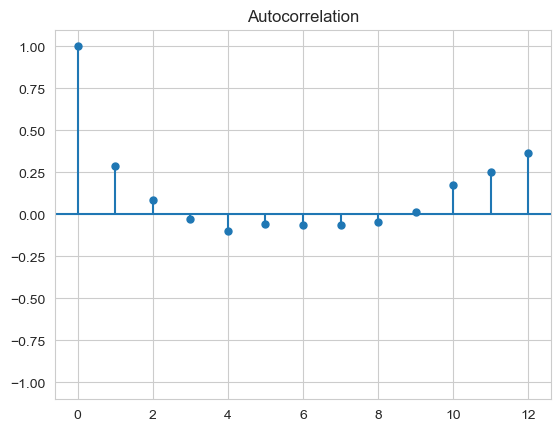

In [73]:
for i in range(1,13):
    print(i)
    sm.graphics.tsa.plot_acf(p_train.interest_level.diff(i)[i:],
                                alpha = None,
                                lags = 12)




    plt.ylim([-1.1,1.1])

    plt.show()

##### c.

While traditional $\text{ARIMA}$ models do not work well for seasonal data, there are seasonal ARIMA ($\text{SARIMA}$) models as well. Recall for an $\text{ARIMA}$ model you needed parameters $p$, $d$ and $q$. For a $\text{SARIMA}$ model you need parameters $P$, $D$, $Q$ and $m$ here:

- $P$ is the order of the seasonal autoregressive portion of the model,
- $Q$ is the order of the seasonal moving average portion of the model,
- $D$ is the order of the seasonal differencing and
- $m$ is the number of time steps that take place in a single period.

You should have an idea of a value for $D$ from <i>b.</i> and we know $m=12$. In this problem you will fit a $\text{SARIMA}$ model on the pumpkin spice data using `statsmodels` `SARIMAX`. Choose whatever values you would like for $p$, $P$, $q$ and $Q$.

In [77]:
p = 1
q = 1
P = 1
D = 1
Q = 1


sarima = SARIMAX(p_train.interest_level.values,
                    order = (p,0,q), 
                    seasonal_order = (P,D,Q,12)).fit(maxiter=200) 

In [ ]:
arima_rmses = np.zeros((5, 3, 3, 3,3))

ps = range(1,4)
qs = range(1,4)
Ps = range(1,4)
Qs = range(1,4)

i = 0
for train_index, test_index in cv.split(p_train):
    p_tt = p_train.loc[train_index]
    p_ho = p_train.loc[test_index]
    
    j = 0
    for p in ps:
        k = 0
        for q in qs:
            l = 0
            for P in Ps:
                m = 0
                for Q in Qs:
                    arima = SARIMAX(p_tt.interest_level.values,order=(p,0,q),seasonal_order=(P,1,Q,12)).fit(maxiter=200)


                    arima_rmses[i,j,k,l,m] = np.sqrt(mean_squared_error(p_ho.interest_level.values,arima.forecast(len(p_ho))))
                    
                    m += 1
                l = l + 1
            k = k +1
        j = j + 1
    i = i +1
    print(i)

C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tuthill.15\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tuthill

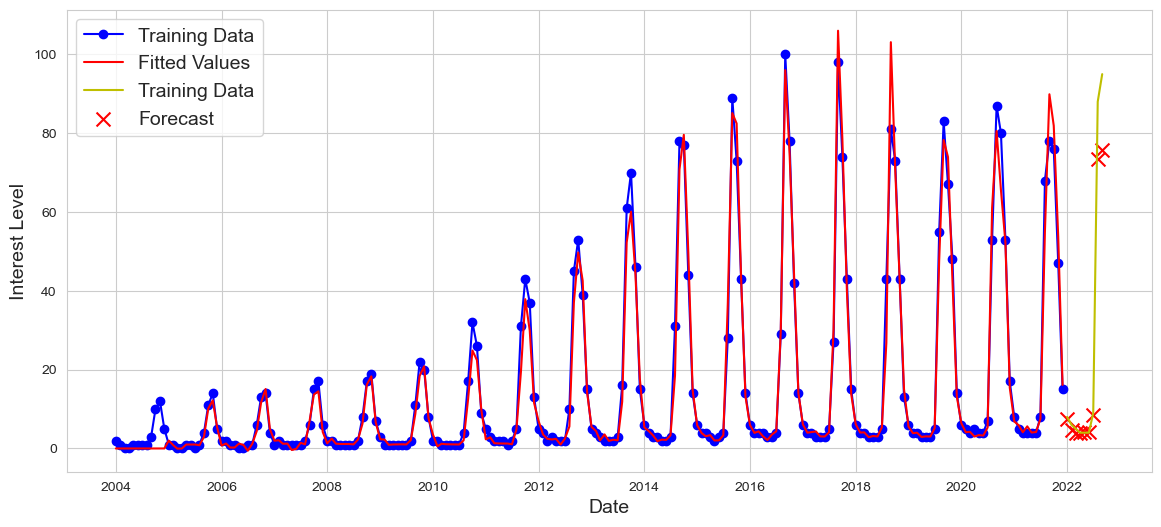

In [78]:
plt.figure(figsize=(14,6))

plt.plot(p_train.Month,p_train.interest_level,
            'b-o',
            label='Training Data')

plt.plot(p_train.Month,sarima.fittedvalues,
            'r',
            label='Fitted Values')

plt.plot(p_test.Month,p_test.interest_level,
            'y',
            label='Training Data')

plt.scatter(p_test.Month,sarima.forecast(len(p_test)),
               c='r',
               marker='x',
               s=100,
               label="Forecast")

plt.legend(fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Interest Level", fontsize=14)

plt.show()

##### d. 

Get the average cross-validation MSE for the SARIMA model you fit above. Use 5-fold cross-validation with a test set size of 12.


How does it compare to the baseline models from `Fall Problem Session 5`? <i>Feel free to use the answer from the completed version `Fall Problem Session 5` if you did not complete it</i>.

In [81]:
cv = TimeSeriesSplit(5,test_size=12)

In [82]:
rmses = np.zeros(5)

i = 0
for train_index, test_index in cv.split(p_train):
    p_tt = p_train.iloc[train_index]
    p_ho = p_train.iloc[test_index]
    
    sarima = SARIMAX(p_tt.interest_level.values,
                    order = (1,0,1), 
                    seasonal_order = (1,1,1,12)).fit(maxiter=200) 
    
    rmses[i] = np.sqrt(mean_squared_error(p_ho.interest_level.values,sarima.forecast(len(p_ho))))
    
    i = i + 1

In [83]:
np.mean(rmses)

5.462267942372099

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)